<a href="https://colab.research.google.com/github/bulentsoykan/IDS6938-Computational-Optimization-Models-and-Methods/blob/main/Routing_problem_Hill_Climbing_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shortest Path from Partnership 3 Building to UCF Main Library

In this Jupyter Notebook, we will explore how to find the shortest path from the Partnership 3 building to the UCF main library using informed search algorithms. The search space is represented by a road network where intersections and points of interest (e.g., origin and destination) are nodes, and edges/arcs represent road segments with weights. We will utilize various Python libraries to model the road network, perform the search, and visualize the results.


## Importing Necessary Libraries

To help find the shortest path in a road network from the Partnership 3 building to the UCF main library using informed search algorithms, we need to import several libraries. Below is an explanation of each import and its purpose:

1. **itertools (islice)**
   - `islice` from the `itertools` module allows for iterator slicing, which can be useful when we need to take a specific number of items from an iterator.
   - **Example Usage**: Extracting a subset of elements from an iterator without materializing the whole iterator into memory.

2. **sys (getsizeof)**
   - `getsizeof` from the `sys` module helps to get the size of an object in bytes.
   - **Example Usage**: Measuring memory usage of different data structures to optimize performance.

3. **time (process_time)**
   - `process_time` from the `time` module provides a way to measure the CPU processing time.
   - **Example Usage**: Profiling the performance and runtime of different algorithms to find the shortest path.

4. **matplotlib.pyplot**
   - `matplotlib.pyplot` is a state-based interface for `matplotlib`, a comprehensive library for creating static, animated, and interactive visualizations in Python.
   - **Example Usage**: Plotting graphs and visualizations to represent the road network and paths.

5. **copy**
   - The `copy` module provides the ability to create shallow or deep copies of objects.
   - **Example Usage**: Duplicating data structures while ensuring that changes to the new copy do not affect the original.

6. **math**
   - The `math` module provides access to mathematical functions.
   - **Example Usage**: Performing mathematical calculations like distance computations and heuristic calculations during informed search.

7. **random**
   - The `random` module implements pseudo-random number generators for various distributions.
   - **Example Usage**: Simulating scenarios or initializing random data points if needed.

8. **collections (deque)**
   - `deque` from the `collections` module provides a double-ended queue which can be quickly appended or popped from both ends.
   - **Example Usage**: Implementing queues, such as for breadth-first search or other search algorithms.

9. **networkx**
   - `networkx` is a library for creating, manipulating, and studying complex networks of nodes and edges.
   - **Example Usage**: Modeling the road network as a graph and performing graph-based operations to find the shortest path.

10. **osmnx**
    - `osmnx` is a Python library for downloading and assembling street networks from OpenStreetMap.
    - **Example Usage**: Fetching the road network data for the area around the Partnership 3 building and UCF main library.

11. **folium**
    - `folium` is a library that makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map.
    - **Example Usage**: Mapping paths, visualizing nodes (e.g., intersections), and displaying the shortest route on an interactive map.

12. **folium.plugins**
    - `folium.plugins` contains useful plugins/extensions for `folium`.
    - **Example Usage**: Adding extra functionality to maps, such as markers, clusters, heatmap visualizations, etc.


In [68]:
%pip install -q osmnx
from itertools import islice
from sys import getsizeof
from time import process_time
import matplotlib.pyplot as plt
import copy
import math
import random
from collections import deque
import networkx as nx
import osmnx
import folium
import folium.plugins

## Node Class

The `Node` class is designed to represent a node in a graph for the purposes of pathfinding and network traversal. This class encapsulates detailed information about each node and provides various methods to interact with and manipulate the nodes within the graph.

### Class Definition

- **`__slots__`**: Used for optimization by explicitly declaring data members. This can reduce memory overhead by preventing the creation of instance dictionaries.
- **Constructor (`__init__`)**: Initializes a node with the following attributes:
  - `node`: The dictionary of each node as retrieved from `networkx` graph.
  - `distance`: The distance from the parent node (edge length).
  - `parent`: Reference to the parent node.
  - `osmid`: Unique identifier for the node.
  - `G`: The entire graph in which the node exists.

### Methods

#### Getters and Setters

- **`get_id`**: Returns the unique identifier of the node (`osmid`).
- **`get_distance`**: Returns the distance attribute of the node.
- **`set_distance`**: Sets the distance attribute of the node.
- **`set_parent`**: Sets the parent attribute of the node.

#### Node Expansion

- **`expand`**: Returns all nodes adjacent to the current node, either by outbound or inbound edges:
  - **Parameters**:
    - `reverse`: Indicates whether to look at inbound or outbound edges.
    - `attr_name`: The attribute name to fetch the distance or weight of the edge.
  - **Outbound Edges**: Looks at the edges starting from the current node to its children.
  - **Inbound Edges**: Looks at the edges coming into the current node from its parent.

#### Path Retrieval

- **`path`**: Returns the path from the current node to the origin as a list and the length of that path:
  - Collects nodes from the current node back to the origin.
  - Reverses the path to show it from origin to the current node.

#### Comparison Methods

- **`__eq__`**: Defines equality comparison for `Node` objects:
  - Nodes are considered equal if their `osmid`s are equal.
- **`__hash__`**: Returns the hash of the `osmid`, making the `Node` hashable and suitable for use in sets and as dictionary keys.

### Summary

The `Node` class is a versatile and optimized representation of graph nodes, essential for pathfinding algorithms. It provides mechanisms for:
- Maintaining node attributes and relationships.
- Expanding to adjacent nodes.
- Retrieving paths.
- Facilitating comparisons and hash operations.

By understanding and utilizing this class, we can effectively perform operations needed to find the shortest path in a graph, especially within a road network.

In [69]:
class Node:
    # using __slots__ for optimization
    __slots__ = ['node', 'distance', 'parent', 'osmid', 'G']
    # constructor for each node
    def __init__(self ,graph , osmid, distance = 0, parent = None):
        # the dictionary of each node as in networkx graph --- still needed for internal usage
        self.node = graph[osmid]

        # the distance from the parent node --- edge length
        self.distance = distance

        # the parent node
        self.parent = parent

        # unique identifier for each node so we don't use the dictionary returned from osmnx
        self.osmid = osmid

        # the graph
        self.G = graph

    # retrieve the osmid
    def get_id(self):
        return self.osmid

    def get_distance(self):
        return self.distance

    def set_distance(self, distance):
        self.distance = distance

    def set_parent(self, parent):
        self.parent = parent

    # returning all the nodes adjacent to the node
    def expand(self, reverse=False, attr_name='length'):
        children = []
        if not reverse:
            # Look at outbound edges
            for id, child in self.G.out_edges(self.osmid):
                try:
                    dist = self.G[id][child][0][attr_name]
                except:
                    dist = self.G[id][child][attr_name]
                children.append(Node(graph = self.G, osmid = child, distance = dist, parent = self))
        else:
            # Look at inbound edges
            for child, id in self.G.in_edges(self.osmid):
                try:
                    dist = self.G[child][id][0][attr_name]
                except:
                    dist = self.G[child][id][attr_name]
                children.append(Node(graph = self.G, osmid = child, distance = dist, parent = self))
        return children

    # returns the path from that node to the origin as a list and the length of that path
    def path(self):
        node = self
        path = []
        while node:
            path.append(node.osmid)
            node = node.parent
        return path[::-1]

    # the following two methods are for dictating how comparison works

    def __eq__(self, other):
        try:
            return self.osmid == other.osmid
        except:
            return self.osmid == other


    def __hash__(self):
        return hash(self.osmid)

## Solution Class

The `Solution` class is designed to encapsulate the results and performance metrics of a pathfinding or search algorithm. This class provides a structured way to store and access important information about the search process and its outcomes.

### Class Definition

- **Constructor (`__init__`)**: Initializes a `Solution` object with the following attributes:
  - `result`: The result of the search algorithm, typically the path found from the start to the goal node.
  - `time`: The execution time taken by the algorithm to find the result.
  - `space`: The amount of memory space used by the algorithm during its execution.
  - `explored`: The list or set of nodes that were explored during the search process.

### Attributes

- **`result`**: Represents the output or final path found by the search algorithm. This could be a list of nodes representing the path from the start to the goal.
- **`time`**: The CPU time consumed by the algorithm to complete the search. This metric helps in understanding the efficiency of the algorithm in terms of time complexity.
- **`space`**: The memory usage of the algorithm, providing insights into the space complexity and the memory footprint during the search process.
- **`explored`**: The collection of nodes that were visited or processed during the search. This attribute can be used to analyze the algorithm's behavior and its exploration strategy.

### Summary

The `Solution` class serves as a container for storing:
- The result of the search (e.g., the path found).
- Performance metrics, including execution time and memory usage.
- The nodes that were explored during the search.

By encapsulating these details, the `Solution` class provides a comprehensive overview of the search algorithm's performance and outcome, facilitating easier analysis and comparison of different algorithms.

In [70]:
class Solution:
    def __init__(self, result, time, space, explored):
        self.result = result
        self.time = time
        self.space = space
        self.explored = explored

## cost Function

The `cost` function is designed to calculate the total weight (or cost) of a given route in a graph. This function is essential for evaluating the efficiency or optimality of a path found by pathfinding algorithms.

### Function Definition

### Purpose
The primary purpose of the `cost` function is to sum up the weights of all edges in a given route within a graph and return the total weight.

### Parameters
- **`G`**: The graph in which the route exists. Typically, this is a NetworkX graph object.
- **`route`**: A list of nodes representing the path for which the total cost is to be calculated.
- **`attr_name`**: The name of the edge attribute to use as the weight. The default attribute is `'length'`.

### Functionality
1. **Initialization**: The function starts by initializing the `weight` variable to zero, which will accumulate the total cost of the route.
2. **Iterating Through the Route**: Using the `zip` function, the route is iterated pairwise (i.e., `u`, `v` where `u` and `v` are consecutive nodes in the route).
3. **Edge Weight Retrieval**:
    - **Try Block**: Attempts to retrieve the edge weight using the specified `attr_name`. If the edge has multiple attributes (i.e., a list of dictionaries), it assumes the weight is in the first dictionary `[0][attr_name]`.
    - **Except Block**: If the edge only has a single dictionary of attributes, it retrieves the weight directly using `[attr_name]`.
4. **Total Weight Calculation**: The weight for each edge is added to the `weight` variable.
5. **Rounding and Return**: The final weight is rounded to four decimal places and returned.

### Output
- The function returns the total rounded weight of the route, which represents the combined cost of traversing all edges in the specified path.

### Summary
The `cost` function is a utility that:
- Calculates the total weight of a route in a graph based on a specified edge attribute.
- Handles both single-attribute and multi-attribute edge representations.
- Provides a rounded total cost value for easy interpretation and comparison.

This function is crucial for evaluating the performance of different paths, assisting in determining the most efficient or optimal route in various pathfinding and network traversal scenarios.

In [71]:
def cost(G, route, attr_name='length'):
    weight = 0
    for u, v in zip(route, route[1:]):
        try:
            weight += G[u][v][0][attr_name]
        except:
            weight += G[u][v][attr_name]
    return round(weight,4)

## get_child Function Explanation

The `get_child` function is designed to generate new routes by attempting to repair a given route in a graph where certain nodes may have failed. This function uses a shortest-path algorithm to find alternative sub-routes between pairs of nodes while avoiding the failing nodes.

### Function Definition

### Purpose
The primary purpose of the `get_child` function is to iterate through potential sub-routes within a given route and yield modified routes that bypass failing nodes using alternative paths.

### Parameters
- **`G`**: The graph in which the route exists. Typically, this is a NetworkX graph object.
- **`route`**: A list of nodes representing the initial path.

### Functionality
1. **Iterating Through Sub-Routes**:
    - The outer **for-loop** iterates through each possible starting index `i` of sub-routes within the given route.
    - The inner **for-loop** iterates through each possible ending index `j` of sub-routes within the given route.
2. **Deep Copy of Route and Failing Nodes**:
    - `deepcopy` is used to create copies of the `route` and the sub-route (`failing_nodes`). This prevents modifying the original list, as lists are passed by reference in Python.
3. **Finding Alternative Sub-Routes**:
    - Calls `shortest_path_with_failed_nodes` to find the shortest path between `stitched[i-1]` and `stitched[j+1]` while avoiding the failing nodes. `stitched` and `failing_nodes` are used to represent the current route segments under consideration.
4. **Handling Disconnected Graph**:
    - If the alternative route cannot be found (i.e., the graph becomes disconnected due to articulation nodes), the function continues to the next iteration using `continue`.
5. **Stitching the Route**:
    - The original sub-route (`route[i:j+1]`) is replaced with the new sub-route found, excluding the first and last nodes since they are already included in the parent route.
6. **Yielding the Modified Route**:
    - The modified route (`stitched`) is yielded, representing a repaired route that avoids the failing nodes.

### Output
- The function is a generator that yields new route lists, each representing a potential path where segments have been repaired to avoid failing nodes.

### Summary
The `get_child` function is a utility that:
- Iterates through sub-routes within a given route to find alternative paths around failing nodes.
- Utilizes another function (`shortest_path_with_failed_nodes`) to obtain the shortest path between segments, ensuring the graph remains connected.
- Yields modified routes that represent viable alternatives to the original path, bypassing problematic segments.

This function is particularly useful in network resilience and reliability studies, where it's crucial to maintain connectivity despite node failures. By generating alternative routes, it helps in finding robust paths in the given road network.

In [72]:
def get_child(G, route):
    for i in range(1, len(route) - 1):
        for j in range(i, len(route) -1):
            # we can't work on the route list directly
            # because lists are passed by reference
            stitched = copy.deepcopy(route)
            failing_nodes = copy.deepcopy(route[i:j+1])
            to_be_stitched = shortest_path_with_failed_nodes(G, stitched, stitched[i-1], stitched[j+1], failing_nodes)

            # this would happen because one of the failing
            # nodes are articulation node and caused the graph
            # to be disconnected
            if to_be_stitched == math.inf: continue

            stitched[i:j+1] = to_be_stitched[1:-1]      # we need to skip the first and starting nodes of this route
                                                        # because these nodes already exit
            yield stitched

## Extracting and Preparing the Road Network Data

In this section, we fetch and prepare the road network data around the University of Central Florida (UCF) and set up the starting and destination points for our pathfinding algorithms.

### Setting Up the Graph

- **Coordinates for UCF**: The coordinates `(28.599218297160498, -81.20237127834936)` represent the central point of UCF.
- **Fetching the Graph**: We use the `osmnx.graph_from_point` function to fetch the graph data around the UCF campus within a 300-meter radius. The options `clean_periphery=True` and `simplify=True` ensure that the graph is cleaned and simplified for easier manipulation.

### Setting Up the Points

- **Origin**: The coordinates for the Partnership III Building are `(28.585246689434186, -81.19929710475674)`.
- **Destination**: The coordinates for the UCF John C. Hitt Library are `(28.600288618223175, -81.2014909203436)`.

### Finding Nearest Nodes

- **Nearest Nodes**: Using the `osmnx.distance.nearest_nodes` function, we find the nearest graph nodes to the given origin and destination coordinates.
  - `origin_id`: The OSM ID for the node nearest to the Partnership III Building.
  - `destination_id`: The OSM ID for the node nearest to the UCF John C. Hitt Library.

### Node Conversion

- **Convert to Node Objects**:
  - **`origin`**: A `Node` object is created using the graph `G` and `origin_id`.
  - **`destination`**: A `Node` object is created using the graph `G` and `destination_id`.

### Summary

In this portion of the notebook, we:
1. Define the central point of UCF.
2. Fetch the road network data surrounding UCF using osmnx.
3. Set up the origin (Partnership III Building) and destination (UCF John C. Hitt Library) points.
4. Use osmnx to find the nearest graph nodes to these points.
5. Convert the identified nodes into `Node` objects for further pathfinding operations.

This preparation is crucial for accurately modeling the road network and ensuring that our pathfinding algorithms operate on realistic and relevant data.

In [73]:
ucf = (28.599218297160498, -81.20237127834936)
G = osmnx.graph_from_point(ucf, dist=300, clean_periphery=True, simplify=True)

# Set up the points
origin = (28.585246689434186, -81.19929710475674) # Partnership III Building
destination = (28.600288618223175, -81.2014909203436) # UCF John C. Hitt Library

# Get the osmid of the nearest nodes to the points
origin_id = osmnx.distance.nearest_nodes(G, origin[1], origin[0])
destination_id = osmnx.distance.nearest_nodes(G, destination[1], destination[0])

# Convert the source and destination nodes to Node
origin = Node(graph=G, osmid=origin_id)
destination = Node(graph=G, osmid=destination_id)

/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:106: FutureWarning: The clean_periphery argument has been deprecated and will be removed in the v2.0.0 release. Future behavior will be as though clean_periphery=True. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = graph_from_polygon(


## Hill Climbing Search Algorithm

The `Hill_Climbing` function is an implementation of the hill climbing search algorithm designed to find a path from an origin to a destination within a graph. This function uses a heuristic approach to iteratively improve upon a solution by exploring neighboring routes and selecting the one with the lowest cost.

### Function Definition

#### Parameters
- **`G`**: The graph in which the search is conducted. Typically, this is a NetworkX graph object.
- **`origin`**: The starting node for the search, represented as a `Node` object.
- **`destination`**: The goal node for the search, represented as a `Node` object.
- **`n`**: The number of neighbors to consider during each iteration.

### Functionality

1. **Time Tracking**:
   - The function begins by recording the start time using `process_time` to track the total execution time of the hill climbing algorithm.

2. **Cost Visualization**:
   - An empty list `costs` is initialized to store the costs of the routes over time.

3. **Initial Search**:
   - **Randomized Search**: The function starts with an initial route obtained using a randomized search algorithm. This initial route is stored in `current`.
   - **Initial Cost Calculation**: The cost of the initial route is calculated using the `cost` function and is appended to the `costs` list.

4. **Neighbor Exploration**:
   - **Generating Neighbors**: The function generates neighboring routes using the `get_child` generator function, considering up to `n` neighbors.
   - **Space Tracking**: The memory space required for storing the neighbors is measured using `getsizeof`.
   - **Finding Shortest Neighbor**: Among the generated neighbors, the route with the lowest cost is identified as `shortest`.

5. **Iterative Improvement**:
   - A while loop is used to iteratively explore and update the current route:
     - If the cost of the shortest neighbor is less than the cost of the current route, the current route is updated to the shortest neighbor.
     - New neighbors are generated from the updated current route, and the shortest neighbor among them is identified.
     - The new cost is calculated and appended to the `costs` list.

6. **Completion**:
   - When no shorter neighbor can be found, the loop terminates, and the final route is stored in `route`.
   - The end time is recorded using `process_time`.
   - The function returns a `Solution` object containing the final route, total execution time, memory space required, and the list of costs over time.

### Output
- **`Solution` Object**:
  - **`route`**: The final path found by the hill climbing algorithm.
  - **`time`**: Total CPU time taken for the search.
  - **`space`**: Memory space required during the neighbor exploration.
  - **`explored`**: List of costs over time, representing the improvement of the route.

### Summary
The `Hill_Climbing` function is a heuristic search approach that starts with a random initial route and iteratively improves the solution by exploring neighboring routes. By continuously selecting the route with the lowest cost, the algorithm converges to a local minimum. This implementation provides a structured way to find paths in a graph while tracking performance metrics such as time and space complexity.

In [74]:
def Hill_Climbing(G, origin, destination, n):
    time_start = process_time()  # Time tracking

    # Visualize the costs over time
    costs = []

    current = randomized_search(G, origin.osmid, destination.osmid)
    costs.append(cost(G, current))
    print("Initial cost:", costs[0])

    neighbours = list(islice(get_child(G, current), n))
    space_required = getsizeof(neighbours)
    shortest = min(neighbours, key=lambda route: cost(G, route))

    print("Initial min(children):", cost(G, shortest))
    while cost(G, shortest) < cost(G, current):
        current = shortest
        neighbours = list(islice(get_child(G, current), n))
        shortest = min(neighbours, key=lambda route: cost(G, route))
        costs.append(cost(G, current))
        print(f"Current cost:", costs[-1], "|", "min(children):", cost(G, shortest))

    route = current
    time_end = process_time()  # Time tracking
    return Solution(route, time_end - time_start, space_required, costs)

## randomized_search Function

The `randomized_search` function is an implementation of a randomized graph traversal algorithm designed to find a path from a source to a destination node. This function introduces an element of randomness in path selection to explore different paths in the graph.

### Function Definition

### Purpose
The primary purpose of the `randomized_search` function is to find a path between a source and destination node in a graph by randomly selecting nodes to expand. This method can help in exploring diverse paths, which can be beneficial in scenarios like randomized search or simulating multiple search strategies.

### Parameters
- **`G`**: The graph in which the search is conducted. Typically, this is a NetworkX graph object.
- **`source`**: The starting node for the search, represented as a node ID (osmid) from the graph.
- **`destination`**: The goal node for the search, represented as a node ID (osmid) from the graph.

### Functionality

1. **Node Initialization**:
   - Creates `Node` objects for both the `origin` (source) and `destination`.

2. **Initial Setup**:
   - Initializes an empty list `route` to store the resulting path.
   - Initializes a `deque` named `frontier` with the `origin` node. The frontier represents nodes to be explored.
   - Initializes a set `explored` to keep track of nodes that have already been visited.

3. **Main Loop (Randomized Traversal)**:
   - The loop continues until there are no nodes left in the frontier.
   - Selects a node randomly from the `frontier` using `random.choice`. This introduces randomness in the path selection.
   - Removes the selected node from the frontier and adds its `osmid` to the `explored` set.

4. **Node Expansion**:
   - For each child node of the current node (expanded using the `expand` method):
     - Checks if the child node is neither in `explored` nor in `frontier`.
     - If the child node is the `destination`, the function calls the `path` method to generate the path from the source to the destination and returns it.
     - If not, the child node is added to the `frontier` for further exploration.

5. **Exception Handling**:
   - If the loop ends without finding the destination, the function raises an exception indicating that the source and destination nodes are not in the same connected component of the graph.

### Output
- The function returns the path from the source to the destination as a list of node IDs (osmids) if it successfully finds a path.
- Raises an exception if the source and destination nodes are not connected.

### Summary
The `randomized_search` function is a randomized exploration algorithm that:
- Introduces randomness in node selection to explore various paths in a graph.
- Finds a valid path from a source node to a destination node.
- Utilizes sets and deques for efficient tracking of explored nodes and the frontier.
- Provides an alternative to deterministic search algorithms, potentially offering diverse path solutions.

This function can be useful in scenarios where the search space is vast, and multiple search strategies need to be simulated or when exploring different paths through randomness can yield better results.

In [75]:
def randomized_search(G, source, destination):
    origin = Node(graph = G, osmid = source)
    destination = Node(graph = G, osmid = destination)

    route = [] # the route to be yielded
    frontier = deque([origin])
    explored = set()
    while frontier:
        node = random.choice(frontier)   # here is the randomization part
        frontier.remove(node)
        explored.add(node.osmid)

        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route = child.path()
                    return route
                frontier.append(child)

    raise Exception("destination and source are not on same component")

## shortest_path_with_failed_nodes Function

The `shortest_path_with_failed_nodes` function aims to find the shortest path between a source and target node in a graph, while considering certain nodes as failed or unavailable. This function employs a variation of Dijkstra's algorithm to avoid failed nodes and ensure connectivity.

### Function Definition

### Purpose
The primary purpose of the `shortest_path_with_failed_nodes` function is to compute an alternative path between two nodes in a graph while avoiding specified failing nodes. This ensures that the search is resilient to failures and can still find valid paths when parts of the network are down.

### Parameters
- **`G`**: The graph in which the search is conducted. Typically, this is a NetworkX graph object.
- **`route`**: The initial route (path) being evaluated.
- **`source`**: The starting node for the search.
- **`target`**: The goal node for the search.
- **`failed`**: A list of nodes to be considered as failed or unavailable.

### Functionality

1. **Node Initialization**:
   - Creates `Node` objects for both the `origin` (source) and `destination` (target).

2. **Remove Source/Target from Failed List**:
   - The function ensures that the source and target nodes are not within the failed nodes list as it would make the search meaningless.

3. **Check for Valid Failed List**:
   - If the failed list is empty after removing the source and target nodes, the function returns `math.inf`, indicating failure in the search.

4. **Failure Nodes Dictionary**:
   - Initializes a dictionary (`failure_nodes`) to flag each node in the graph as failed or not.

5. **Tabu List Creation**:
   - Creates a `tabu_list` to avoid loops in the route by excluding nodes already in the evaluated part of the route from being expanded again.

6. **Dijkstra's Algorithm Initialization**:
   - Initializes the `shortest_dist` dictionary to store the shortest distance to each node, initially set to `math.inf`.
   - Creates a list of unrelaxed nodes (`unrelaxed_nodes`) containing all nodes in the graph.
   - Initializes a set (`seen`) to keep track of relaxed nodes.

7. **Main Loop (Relaxation Process)**:
   - The loop continues until no unrelaxed nodes remain.
   - Selects the node with the minimum distance from `shortest_dist`.
   - Checks for disconnected components by verifying if the minimum distance is `math.inf`.

8. **Path Check and Expansion**:
   - If the node equals the destination, the function returns the path from the source to the destination.
   - Removes the node from the unrelaxed list and adds it to `seen`.
   - Expands the current node to evaluate its children.
   - Ensures that child nodes are not failed, seen, or part of the `tabu_list`.
   - Updates distance and parent for each child if a shorter path is found.

9. **Handling Disconnected Graphs**:
   - If the graph becomes disconnected due to articulation nodes or the node cannot be reached, the function returns `math.inf`.

### Output
- The function returns either the path from the source to the destination (if found) or `math.inf` if the path cannot be completed due to failed nodes or disconnections.

### Summary
The `shortest_path_with_failed_nodes` function is a modified Dijkstra's algorithm that:
- Finds alternative paths in a graph while avoiding specified failed nodes.
- Ensures the source and target nodes are always considered valid.
- Handles scenarios where parts of the network are disconnected due to failures.
- Provides a robust solution for network resilience and reliability testing by finding valid paths in the presence of node failures.

This function is crucial for evaluating the resilience of the network and ensuring continued connectivity despite node failures.

In [76]:
def shortest_path_with_failed_nodes(G, route ,source, target, failed : list):
    origin = Node(graph = G, osmid = source)
    destination = Node(graph = G, osmid = target)

    ## you can't introduce failure in the source and target
    # node, because your problem will lose its meaning
    if source in failed: failed.remove(source)
    if target in failed: failed.remove(target)

    # if after removing source/target node from failed
    # list - just return math.inf which is equivalent to failure in search
    if len(failed) == 0: return math.inf

    # we need to flag every node whether it is failed or not
    failure_nodes = {node: False for node in G.nodes()}
    failure_nodes.update({node: True for node in failed})

    # we need to make sure that while expansion we don't expand
    # any node from the original graph to avoid loops in our route
    tabu_list = route[:route.index(source)] \
                + \
                route[route.index(target) + 1:]

    # the normal implementation of dijkstra
    shortest_dist = {node: math.inf for node in G.nodes()}
    unrelaxed_nodes = [Node(graph = G, osmid = node) for node in G.nodes()]
    seen = set()

    shortest_dist[source] = 0

    while len(unrelaxed_nodes) > 0:
        node = min(unrelaxed_nodes, key = lambda node : shortest_dist[node])

        # if we have relaxed articulation nodes in our graph
        # halt the process -- we have more than one component
        # in our graph which makes the question of shortest path
        # invalid

        if shortest_dist[node.osmid] == math.inf: return math.inf

        if node == destination:
            return node.path()

        unrelaxed_nodes.remove(node); seen.add(node.osmid) # relaxing the node

        for child in node.expand():
            # if it is failed node, skip it
            if failure_nodes[child.osmid] or\
                child.osmid in seen or\
                child.osmid in tabu_list:
                continue

            child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
            child_obj.distance = child.distance

            distance = shortest_dist[node.osmid] + child.distance
            if distance < shortest_dist[child_obj.osmid]:
                shortest_dist[child_obj.osmid] = distance
                child_obj.parent = node

    # in case the node can't be reached from the origin
    # this return happens when the node is not on the graph
    # at all, if it was on a different component the second
    # return will be executed -- this is the third return

    return math.inf

## Executing and Evaluating the Hill Climbing Algorithm

In this section, we execute the Hill Climbing search algorithm to find the shortest path from the origin to the destination within the graph. We also evaluate and visualize the performance of the algorithm.

### Executing the Hill_climbing Algorithm

- The `Hill_Climbing` function is called with the graph `G`, the `origin` and `destination` nodes, and the parameter `100` which specifies the number of neighbors to consider during each iteration.
- The function returns a `Solution` object containing the resulting path (`route`), process time, space required, and the list of costs over iterations.

### Retrieving and Printing Results

- **`route`**: Extract the result path from the `Solution` object.
- **Cost Calculation**: The `cost` function is used to calculate the total cost of the resulting path in meters.
- **Process Time**: Print the total CPU time taken by the Hill Climbing algorithm to find the path.
- **Space Required**: Print the memory space required during the neighbor exploration phase.

Example:
```plaintext
Cost: X m
Process time: Y s
Space required: Z bytes

Initial cost: 671.083
Initial min(children): 532.144
Current cost: 532.144 | min(children): 507.739
Current cost: 507.739 | min(children): 518.804
Cost: 507.739 m
Process time: 38.55684140599999 s
Space required: 376 bytes


Text(0.5, 0, 'Iteration')

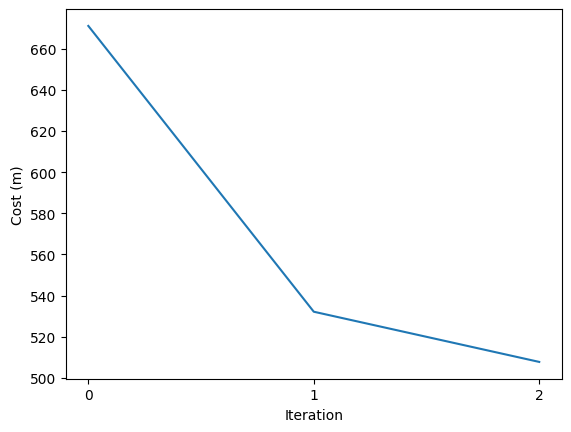

In [77]:
solution = Hill_Climbing(G, origin, destination, 100)
route = solution.result
print(f"Cost: {cost(G,route)} m")
print(f"Process time: {solution.time} s")
print(f"Space required: {solution.space} bytes")
plt.plot(solution.explored)
plt.xticks(list(range(len(solution.explored))))
plt.ylabel("Cost (m)")
plt.xlabel("Iteration")

## draw_route Function

The `draw_route` function is designed to visualize a given route on a map using the Folium library. This function converts the NetworkX graph to GeoDataFrames, extracts the necessary coordinates, and plots the route with interactive and animated features.

### Function Definition

### Purpose
The primary purpose of the `draw_route` function is to create an interactive map that visually represents a given path in a graph. This visualization helps in understanding the geographic traversal of the route.

### Parameters
- **`G`**: The graph containing the route. Typically, this is a NetworkX graph object.
- **`route`**: A list of node IDs representing the path to be visualized.

### Functionality

1. **Convert Graph to GeoDataFrames**:
   - The function uses `osmnx.graph_to_gdfs` to convert the graph `G` into two GeoDataFrames:
     - `nodes_frame`: Contains node information.
     - `ways_frame`: Contains edge (way) information.

2. **Extract Start and End Coordinates**:
   - **Start Node**: Retrieves the coordinates of the starting node in the route.
   - **End Node**: Retrieves the coordinates of the ending node in the route.
   - **Coordinates**: Extracts `(latitude, longitude)` pairs for both the start and end nodes.

3. **Initialize Folium Map**:
   - Creates a Folium map centered at the starting node's coordinates with an initial zoom level.
   - Adds markers at the start and end locations of the route.

4. **Plot Path Segments**:
   - Iterates through each segment of the route using pairs of consecutive nodes.
   - **Query GeoDataFrames**:
     - Retrieves the geometries of the segments (edges) connecting the nodes.
     - Handles both possible directions of traversal (`u` to `v` and `v` to `u`).
   - **Ant Path Layer**: Uses `folium.plugins.AntPath` to create an animated path layer on the map:
     - `locations`: Coordinates of the path points.
     - `dash_array`, `delay`, `color`, `pulse_color`: Styling attributes for the Ant Path.

5. **Return Map**:
   - Returns the created Folium map object with the visualized route.

### Output
- The function returns a Folium map object with the visualized route, including markers for the start and end points and an animated path representing the route.

### Summary
The `draw_route` function is a powerful tool for visualizing paths in a road network. It:
- Converts graph data into geo-referenced formats for easier manipulation.
- Extracts coordinates for start and end points of the route.
- Creates an interactive and animated map using Folium, making it easy to see the path's traversal across geographic space.

This function enhances the understanding and presentation of routes found by pathfinding algorithms, providing a clear and engaging way to display geographic data

In [78]:
def draw_route(G, route):
    G_gdfs = osmnx.graph_to_gdfs(G)
    nodes_frame = G_gdfs[0]
    ways_frame = G_gdfs[1]
    start_node = nodes_frame.loc[route[0]]
    end_node = nodes_frame.loc[route[len(route)-1]]
    start_xy = (start_node['y'], start_node['x'])
    end_xy = (end_node['y'], end_node['x'])

    m = folium.Map(location = start_xy, zoom_start=15)
    folium.Marker(location = start_xy, draggable = False).add_to(m)
    folium.Marker(location = end_xy, draggable = False).add_to(m)

    pathGroup = []
    for u, v in zip(route[0:], route[1:]):
        try:
            geo = (ways_frame.query(f'u == {u} and v == {v}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        except:
            geo = (ways_frame.query(f'u == {v} and v == {u}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        x, y = m_geo.coords.xy
        points = map(list, [*zip([*y],[*x])])
        folium.plugins.AntPath(
            locations = [*points],
            dash_array=[1, 10],
            delay=1000,
            color='red',
            pulse_color='black'
        ).add_to(m)
    #     pathGroup.append(ant_path)
    #     m.add_layer(ant_path)
    # m.fit_bounds(get_paths_bounds(pathGroup))
    return m

In [79]:
draw_route(G,route)